In [1]:
%matplotlib inline


Sequence Models and Long-Short Term Memory Networks
===================================================

At this point, we have seen various feed-forward networks. That is,
there is no state maintained by the network at all. This might not be
the behavior we want. Sequence models are central to NLP: they are
models where there is some sort of dependence through time between your
inputs. The classical example of a sequence model is the Hidden Markov
Model for part-of-speech tagging. Another example is the conditional
random field.

A recurrent neural network is a network that maintains some kind of
state. For example, its output could be used as part of the next input,
so that information can propogate along as the network passes over the
sequence. In the case of an LSTM, for each element in the sequence,
there is a corresponding *hidden state* $h_t$, which in principle
can contain information from arbitrary points earlier in the sequence.
We can use the hidden state to predict words in a language model,
part-of-speech tags, and a myriad of other things.


LSTM's in Pytorch
~~~~~~~~~~~~~~~~~

Before getting to the example, note a few things. Pytorch's LSTM expects
all of its inputs to be 3D tensors. The semantics of the axes of these
tensors is important. The first axis is the sequence itself, the second
indexes instances in the mini-batch, and the third indexes elements of
the input. We haven't discussed mini-batching, so lets just ignore that
and assume we will always have just 1 dimension on the second axis. If
we want to run the sequence model over the sentence "The cow jumped",
our input should look like

\begin{align}\begin{bmatrix}
   \overbrace{q_\text{The}}^\text{row vector} \\
   q_\text{cow} \\
   q_\text{jumped}
   \end{bmatrix}\end{align}

Except remember there is an additional 2nd dimension with size 1.

In addition, you could go through the sequence one at a time, in which
case the 1st axis will have size 1 also.

Let's see a quick example.



In [5]:
# Author: Robert Guthrie

from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)

In [3]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [autograd.Variable(torch.randn((1, 3)))
          for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (autograd.Variable(torch.randn(1, 1, 3)),
          autograd.Variable(torch.randn((1, 1, 3))))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (autograd.Variable(torch.randn(1, 1, 3)), autograd.Variable(
    torch.randn((1, 1, 3))))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

Variable containing:
(0 ,.,.) = 
 -0.0187  0.1713 -0.2944

(1 ,.,.) = 
 -0.3521  0.1026 -0.2971

(2 ,.,.) = 
 -0.3191  0.0781 -0.1957

(3 ,.,.) = 
 -0.1634  0.0941 -0.1637

(4 ,.,.) = 
 -0.3368  0.0959 -0.0538
[torch.FloatTensor of size 5x1x3]

(Variable containing:
(0 ,.,.) = 
 -0.3368  0.0959 -0.0538
[torch.FloatTensor of size 1x1x3]
, Variable containing:
(0 ,.,.) = 
 -0.9825  0.4715 -0.0633
[torch.FloatTensor of size 1x1x3]
)


Example: An LSTM for Part-of-Speech Tagging
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In this section, we will use an LSTM to get part of speech tags. We will
not use Viterbi or Forward-Backward or anything like that, but as a
(challenging) exercise to the reader, think about how Viterbi could be
used after you have seen what is going on.

The model is as follows: let our input sentence be
$w_1, \dots, w_M$, where $w_i \in V$, our vocab. Also, let
$T$ be our tag set, and $y_i$ the tag of word $w_i$.
Denote our prediction of the tag of word $w_i$ by
$\hat{y}_i$.

This is a structure prediction, model, where our output is a sequence
$\hat{y}_1, \dots, \hat{y}_M$, where $\hat{y}_i \in T$.

To do the prediction, pass an LSTM over the sentence. Denote the hidden
state at timestep $i$ as $h_i$. Also, assign each tag a
unique index (like how we had word\_to\_ix in the word embeddings
section). Then our prediction rule for $\hat{y}_i$ is

\begin{align}\hat{y}_i = \text{argmax}_j \  (\log \text{Softmax}(Ah_i + b))_j\end{align}

That is, take the log softmax of the affine map of the hidden state,
and the predicted tag is the tag that has the maximum value in this
vector. Note this implies immediately that the dimensionality of the
target space of $A$ is $|T|$.


Prepare data:



In [3]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), 51).cuda().double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), 51).cuda().double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 51).cuda().double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), 51).cuda().double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

Generate sin data

In [4]:
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

Train the model:



STEP:  0
loss: 0.515870350912
loss: 0.508971783118
loss: 0.491004204205
loss: 0.477035134284
loss: 0.426272323196
loss: 0.730355297077
loss: 0.240492045871
loss: 0.0869845092928
loss: 0.447917125965
loss: 0.0229083948116
loss: 0.0222224897487
loss: 0.0215000664866
loss: 0.0204044735767
loss: 0.0181795582282
loss: 0.014845042549
loss: 0.0104998095971
loss: 0.00508567744752
loss: 0.00448617589406
loss: 0.00361989077646
loss: 0.00303090944134
test loss: 
1.00000e-03 *
  2.6127
[torch.cuda.DoubleTensor of size 1 (GPU 0)]



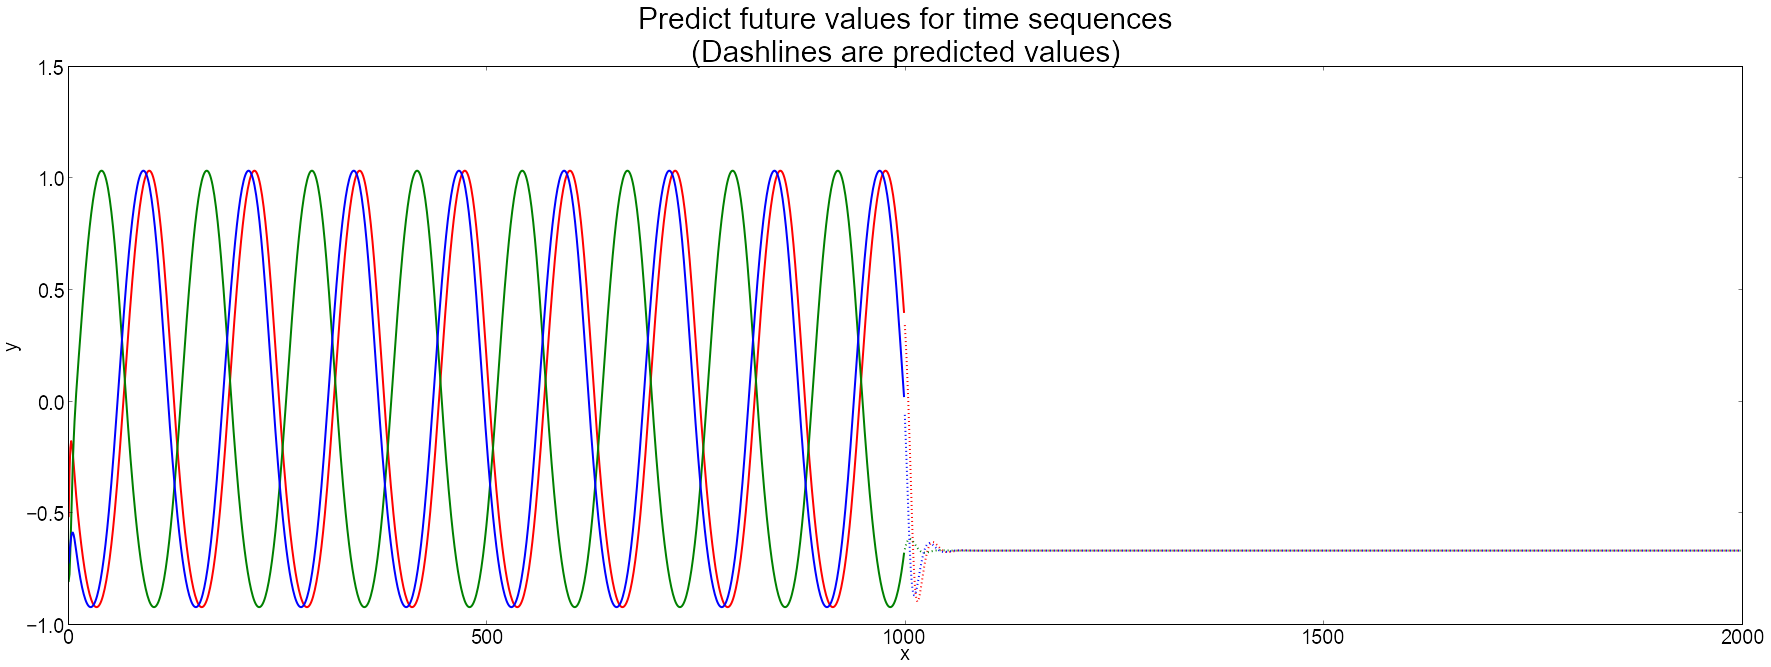

STEP:  1
loss: 0.00265015169619
loss: 0.00240997798182
loss: 0.00214578007276
loss: 0.00187531242452
loss: 0.00154679638099
loss: 0.00119674327605
loss: 0.00082602956013
loss: 0.00078210969767
loss: 0.000764011881103
loss: 0.000745803138509
loss: 0.000704421270577
loss: 0.000623630258474
loss: 0.000473025618542
loss: 0.000337036546906
loss: 0.000240072297488
loss: 0.000223084209384
loss: 0.000222158859959
loss: 0.000221931100267
loss: 0.000221439960197
loss: 0.000220795708359
test loss: 
1.00000e-05 *
  9.7164
[torch.cuda.DoubleTensor of size 1 (GPU 0)]



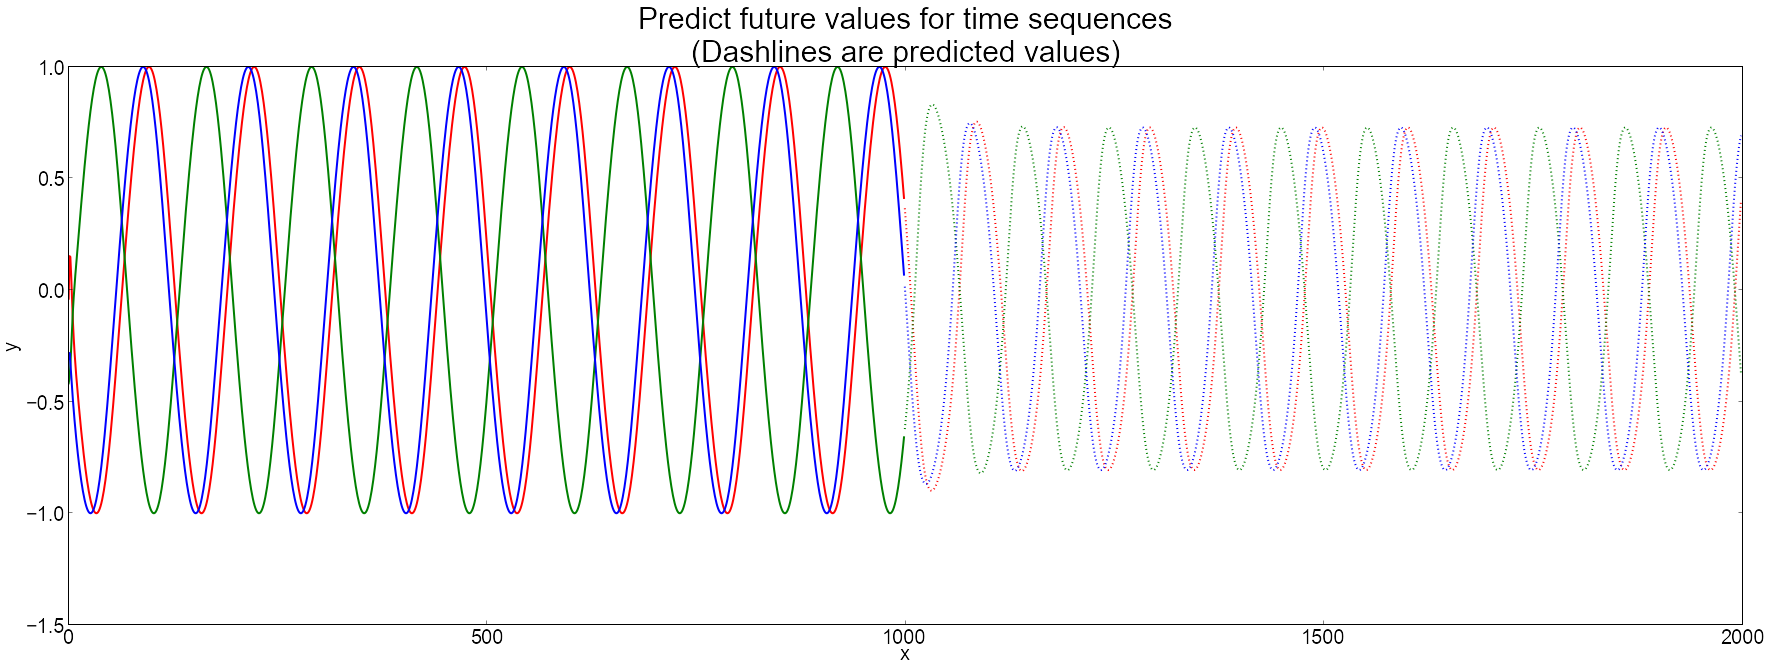

STEP:  2
loss: 0.000220206402351
loss: 0.000219234676531
loss: 0.000214583186918
loss: 0.000204524665964
loss: 0.000195176395626
loss: 0.000183087609544
loss: 0.00017096810378
loss: 0.000166294650188
loss: 0.000165205242688
loss: 0.00016497057585
loss: 0.000164847438555
loss: 0.000164634934008
loss: 0.000164524382881
loss: 0.00016440826719
loss: 0.000164166122413
loss: 0.00016370398438
loss: 0.000162748262501
loss: 0.000160924395765
loss: 0.000157601712553
loss: 0.000151308188002
test loss: 
1.00000e-04 *
  1.0427
[torch.cuda.DoubleTensor of size 1 (GPU 0)]



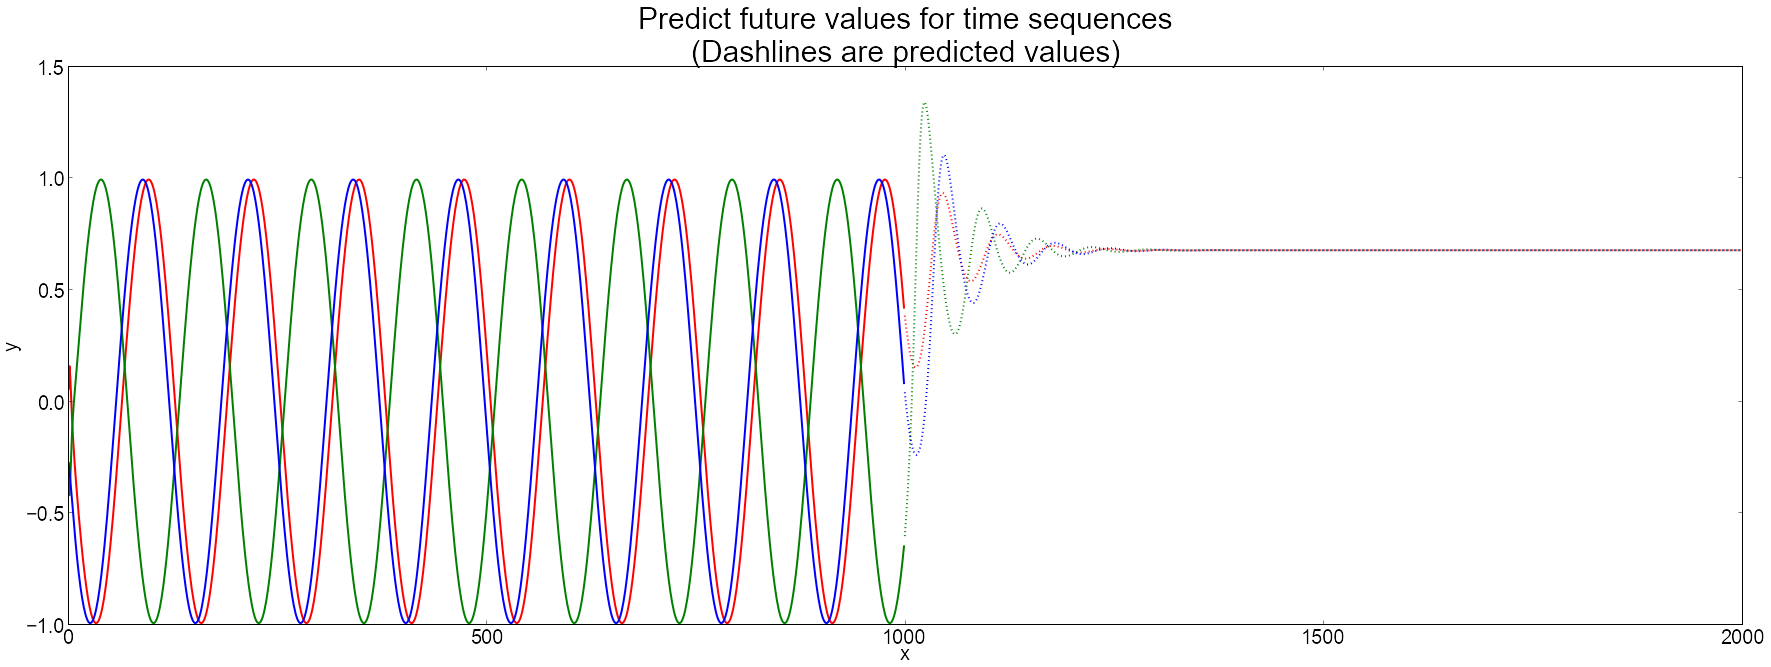

STEP:  3
loss: 0.000190261644872
loss: 0.000148568245904
loss: 0.000152406773515
loss: 0.000137624435001
loss: 0.000160779748782
loss: 0.000116837453961
loss: 0.000113353949564
loss: 0.000102821005545
loss: 9.80150402839e-05
loss: 9.3177701933e-05
loss: 9.04965428083e-05
loss: 8.81453361164e-05
loss: 8.65959092839e-05
loss: 8.58100376358e-05
loss: 8.53995311582e-05
loss: 8.50502708296e-05
loss: 8.47370046608e-05
loss: 8.29163993786e-05
loss: 0.000121840001337
loss: 6.99731739606e-05
test loss: 
1.00000e-05 *
  4.5319
[torch.cuda.DoubleTensor of size 1 (GPU 0)]



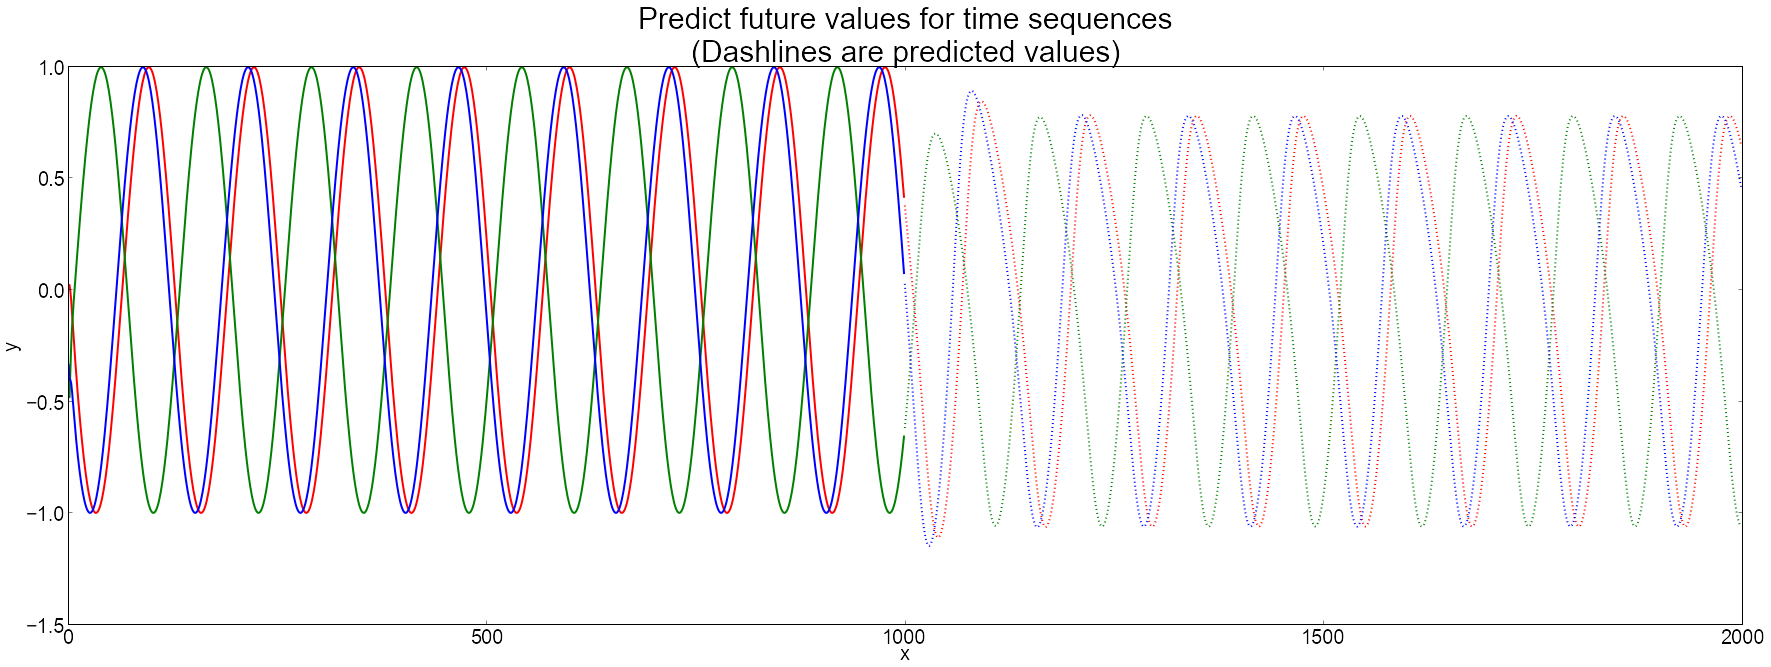

STEP:  4
loss: 6.39130114878e-05
loss: 0.000337876295553
loss: 4.73202957358e-05
loss: 4.55295546517e-05
loss: 4.21389119667e-05
loss: 4.01944873717e-05
loss: 3.88714457105e-05
loss: 3.68375100365e-05
loss: 3.51679012808e-05
loss: 3.3279714725e-05
loss: 3.18466352022e-05
loss: 3.14956500608e-05
loss: 3.13895393705e-05
loss: 3.13248640142e-05
loss: 3.11914606475e-05
loss: 3.09528830993e-05
loss: 3.04094554105e-05
loss: 2.93940926628e-05
loss: 2.7956878416e-05
loss: 2.67095354528e-05
test loss: 
1.00000e-05 *
  2.6981
[torch.cuda.DoubleTensor of size 1 (GPU 0)]



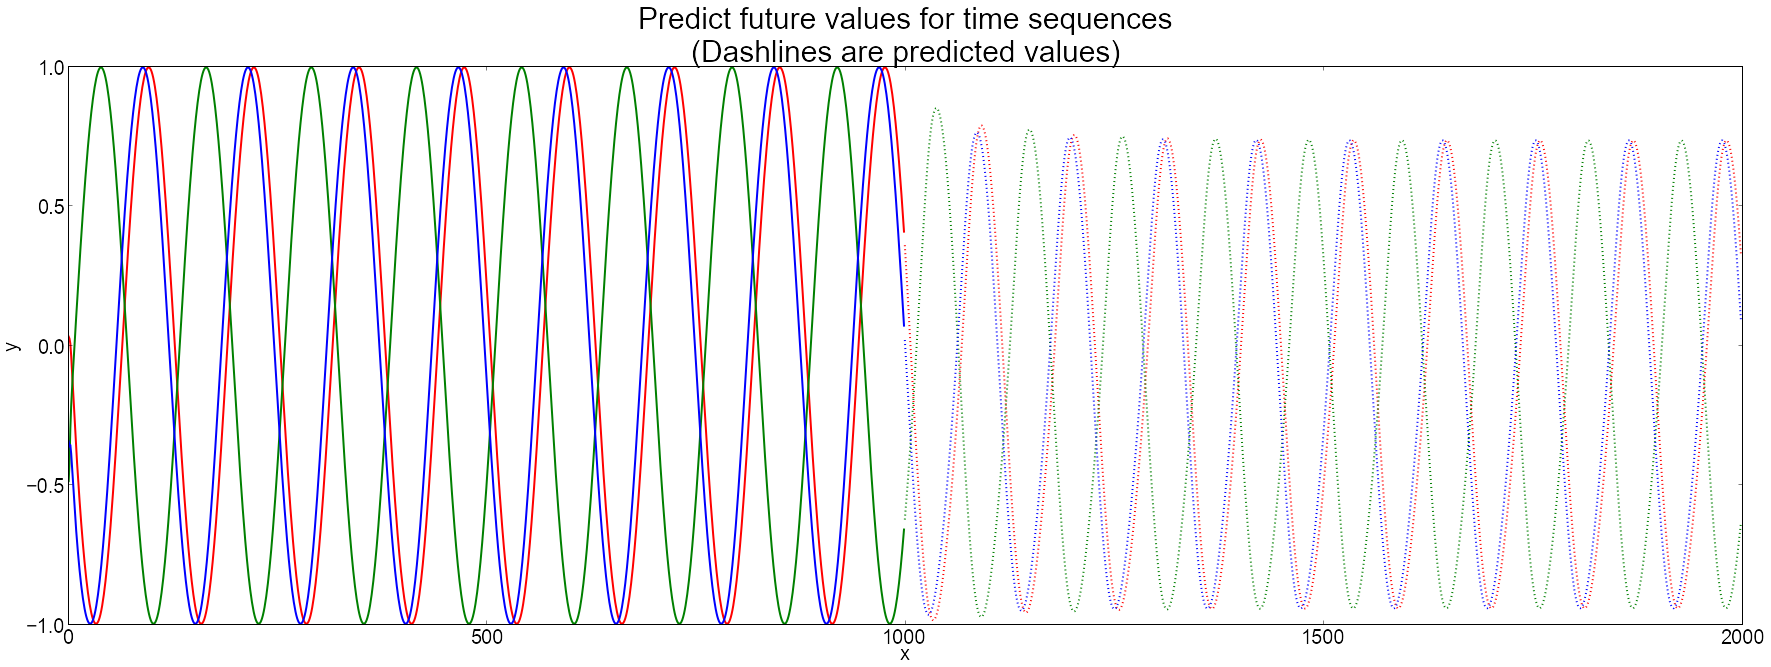

STEP:  5
loss: 2.61722045831e-05
loss: 2.43551394786e-05
loss: 2.2573032813e-05
loss: 2.05561863992e-05
loss: 1.99944369517e-05
loss: 1.99258503523e-05
loss: 1.93698753014e-05
loss: 1.90677681707e-05
loss: 1.87644803809e-05
loss: 1.83776427181e-05
loss: 1.83091018622e-05
loss: 1.82835549115e-05
loss: 1.82526967757e-05
loss: 1.80530879546e-05
loss: 1.61934596104e-05
loss: 1.47368055143e-05
loss: 1.45808567388e-05
loss: 1.40693000566e-05
loss: 1.40245773223e-05
loss: 1.39656356672e-05
test loss: 
1.00000e-05 *
  1.6262
[torch.cuda.DoubleTensor of size 1 (GPU 0)]



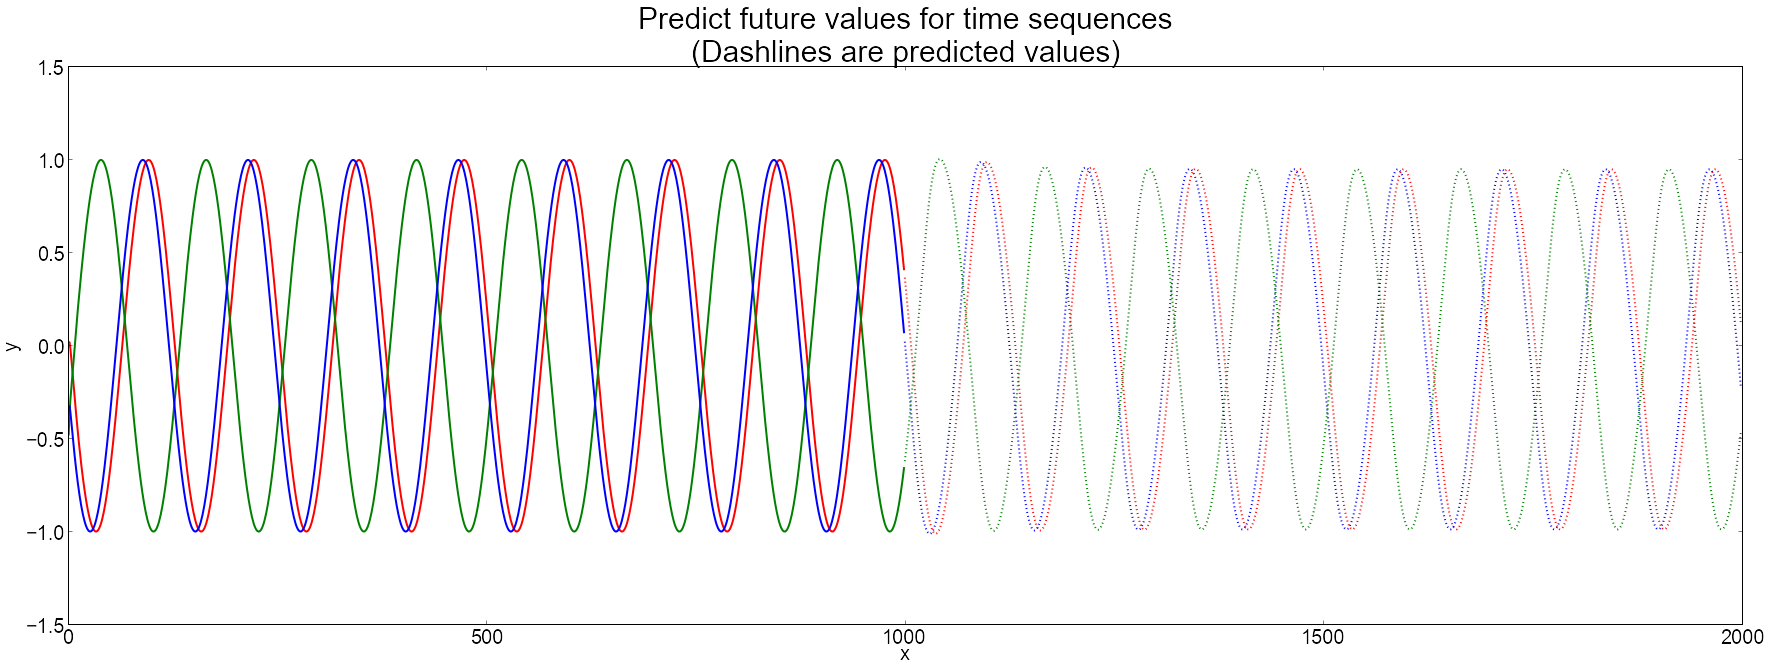

STEP:  6
loss: 1.39494877795e-05
loss: 1.39446370683e-05
loss: 1.39367669114e-05
loss: 1.39036924398e-05
loss: 1.38599398433e-05
loss: 1.3788632541e-05
loss: 1.36325254615e-05
loss: 1.33606976092e-05
loss: 1.31255793208e-05
loss: 1.27640443645e-05
loss: 1.25046584947e-05
loss: 1.18954358516e-05
loss: 1.11674600494e-05
loss: 1.09148734017e-05
loss: 1.08103688782e-05


In [ ]:
# load data and make training set
data = torch.load('traindata.pt')
input = Variable(torch.from_numpy(data[3:, :-1]).cuda(), requires_grad=False)
target = Variable(torch.from_numpy(data[3:, 1:]).cuda(), requires_grad=False)
test_input = Variable(torch.from_numpy(data[:3, :-1]).cuda(), requires_grad=False)
test_target = Variable(torch.from_numpy(data[:3, 1:]).cuda(), requires_grad=False)
# build the model
seq = Sequence().cuda()
seq.double()
params = list(seq.parameters())
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(15):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict
    future = 1000
    pred = seq(test_input, future = future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss:', loss.data)
    y = pred.data.cpu().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()